Data analytics lab. 3 Tomasz Brania 23.03.2023

We are testing a new vaccine, for which we performed a trial on 50 patients registering 7 allergic reactions. We want to verify what is the allergic reaction probability for new trial and what is the probability that it is lower than for normal vacine. We assume that each patient treatment is exchangeable.

Prior and Posterior predictive distributions

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az 
import numpy as np

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N = 50  # number of patients
y = 7   # number of allergic reactions

Modeling prior predictive distribution

In [3]:
gen_quant_prior = CmdStanModel(stan_file='prior.stan')

INFO:cmdstanpy:compiling stan file /home/volume_for_DA/Lab3/prior.stan to exe file /home/volume_for_DA/Lab3/prior
INFO:cmdstanpy:compiled model executable: /home/volume_for_DA/Lab3/prior


In [4]:
samples_prior = gen_quant_prior.sample(fixed_param=True, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [5]:
df = samples_prior.draws_pd()
df.head()

,lp__,accept_stat__,N,y,p
0,0.0,0.0,50.0,32.0,0.720297
1,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.000000


<AxesSubplot:>

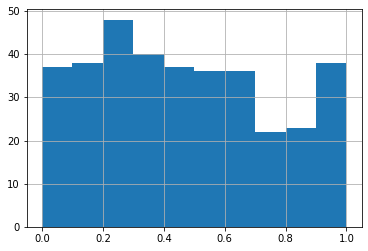

In [6]:
ratio_prior = df['y'] / df['N']
ratio_prior.hist()

In [7]:
ratio_prior.mean()

0.4643380281690141

Modeling posterior and posterior predictive distribution

In [8]:
gen_quant_posterior = CmdStanModel(stan_file='posterior.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
samples_posterior = gen_quant_posterior.sample(data={'N':N, 'y':y})

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▍         | 00:01 Status

chain 1 |▉         | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


In [10]:
df = samples_posterior.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
0,-22.9297,1.000000,0.971628,2.0,3.0,0.0,23.0892,0.104528,7.0
1,-22.8094,1.000000,0.971628,1.0,1.0,0.0,22.9842,0.109245,7.0
2,-22.5339,1.000000,0.971628,1.0,1.0,0.0,22.7546,0.123907,6.0
3,-22.3384,0.993640,0.971628,1.0,3.0,0.0,22.5394,0.156429,7.0
4,-22.3432,0.998599,0.971628,1.0,1.0,0.0,22.3433,0.159266,9.0


<AxesSubplot:>

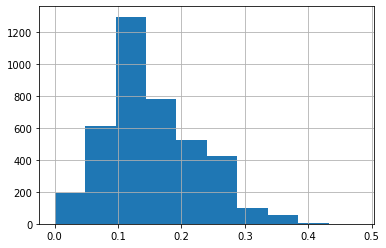

In [11]:
ratio_posterior = df['y_pred'] / N
ratio_posterior.hist()

In [17]:
ratio_posterior_mean = ratio_posterior.mean()
density_interval_posterior = az.hdi(np.array(ratio_posterior))

In [24]:
ratio_p = df['p'].mean()
density_interval_p = az.hdi(np.array(df['p']))

In [28]:
print("Expected value of predicted ratio: ", ratio_posterior_mean)
print("94% density interval of the predicted ratio:", density_interval_posterior)
print("\nExpected value of parameter p: ", ratio_p)
print("94% density interval of parameter p: ", density_interval_p)

Expected value of predicted ratio:  0.15254
94% density interval of the predicted ratio: [0.04 0.28]

Expected value of parameter p:  0.15219388262500003
94% density interval of parameter p:  [0.0600838 0.237948 ]


In [31]:
prob_sum = (ratio_posterior < 0.2).sum()
print("Number of simulated ratios that have smaller probability from traditional vaccines:", prob_sum)

prob = prob_sum / len(ratio_posterior)
print("Probability that ratio is lower than the average probability from traditional vaccines", prob)

Number of simulated ratios that have smaller probability from traditional vaccines: 2889
Probability that ratio is lower than the average probability from traditional vaccines 0.72225
